In [57]:
#Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch import optim


#Import TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchvision.models import resnet
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader



#import other libraries
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from keras.models import Sequential
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import os
import random 
import shutil
from tqdm.auto import tqdm
import zipfile

In [ ]:

# from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl")

# input_text = "translate English to German How old are you?"
# input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# outputs = model.generate(input_ids)
# print(tokenizer.decode(outputs[0]))


In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data pre-processing

1.   First we make Train and Test folders in the main folder
2.   then we extract the labels for gender from the txt files in the folder
3.   Then we create class folders for male and female by transferring the files with the corresponding labels and put it in the train and test folders.



In [ ]:
# # replace 'input_folder' with the name of the folder containing your data in '/kaggle/input/'
# input_folder = 'ubipr-custom-dataset'

# # replace 'working_folder' with the name of the folder where you want to store the copied data in '/kaggle/working/'
# working_folder = 'my-data'

# # copy the contents of the input folder to the working folder
# shutil.copytree(f'/kaggle/input/{input_folder}', f'/kaggle/working/{working_folder}')


In [8]:
# Set the path to your dataset folder
data_folder = '/kaggle/working/my-data/ubipr/UBIPeriocular'

# Set the percentage of data to use for training
train_percent = 0.9

# Get a list of all the image files in the dataset folder
files = os.listdir(data_folder)
image_files = [f for f in files if f.endswith('.jpg')]

# Shuffle the list of image files
random.shuffle(image_files)

# Calculate the split point
split_point = int(len(image_files) * train_percent)

# Split the data into training and testing sets
train_files = image_files[:split_point]
test_files = image_files[split_point:]

# Set the paths for the training and testing folders
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

# Create the training and testing folders if they don't exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Move the training files to the training folder along with their corresponding text file
for file in train_files:
    src_path = os.path.join(data_folder, file)
    dst_path = os.path.join(train_folder, file)
    shutil.move(src_path, dst_path)
    
    # get the corresponding text file and move it along with the image file
    text_file = file.split('.')[0] + '.txt'
    src_text_path = os.path.join(data_folder, text_file)
    dst_text_path = os.path.join(train_folder, text_file)
    shutil.move(src_text_path, dst_text_path)

# Move the testing files to the testing folder along with their corresponding text file
for file in test_files:
    src_path = os.path.join(data_folder, file)
    dst_path = os.path.join(test_folder, file)
    shutil.move(src_path, dst_path)
    
    # get the corresponding text file and move it along with the image file
    text_file = file.split('.')[0] + '.txt'
    src_text_path = os.path.join(data_folder, text_file)
    dst_text_path = os.path.join(test_folder, text_file)
    shutil.move(src_text_path, dst_text_path)



In [9]:
folder_path = '/kaggle/working/my-data/ubipr/UBIPeriocular/test'  # specify the path to the folder with images and txt files
line_num = 7  # The 7th line in the textfile contains the gender label

# create the subfolders 'male' and 'female'
os.makedirs(os.path.join(folder_path, 'male'), exist_ok=True)
os.makedirs(os.path.join(folder_path, 'female'), exist_ok=True)

gender = []

# iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # read the file contents and extract the desired line
        with open(os.path.join(folder_path, filename), 'r') as file:
            img_filename = filename.replace('.txt', '.jpg')
            img_filepath = os.path.join(folder_path, img_filename) 
            lines = file.readlines()
            list_item = lines[line_num - 1].strip().replace(';', '')
            gender.append(list_item)

            # move the file to the appropriate subfolder
            if list_item.lower() == 'male':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'male'))
                shutil.move(img_filepath, os.path.join(folder_path, 'male', img_filename))

            elif list_item.lower() == 'female':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'female'))
                shutil.move(img_filepath, os.path.join(folder_path, 'female', img_filename))



In [10]:
folder_path = '/kaggle/working/my-data/ubipr/UBIPeriocular/train'  # specify the path to the folder with images and txt files
line_num = 7  # The 7th line in the textfile contains the gender label

# create the subfolders 'male' and 'female'
os.makedirs(os.path.join(folder_path, 'male'), exist_ok=True)
os.makedirs(os.path.join(folder_path, 'female'), exist_ok=True)

gender = []

# iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # read the file contents and extract the desired line
        with open(os.path.join(folder_path, filename), 'r') as file:
            img_filename = filename.replace('.txt', '.jpg')
            img_filepath = os.path.join(folder_path, img_filename) 
            lines = file.readlines()
            list_item = lines[line_num - 1].strip().replace(';', '')
            gender.append(list_item)

            # move the file to the appropriate subfolder
            if list_item.lower() == 'male':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'male'))
                shutil.move(img_filepath, os.path.join(folder_path, 'male', img_filename))

            elif list_item.lower() == 'female':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'female'))
                shutil.move(img_filepath, os.path.join(folder_path, 'female', img_filename))




In [ ]:
# #count the number of images in a folder
# folder_path = '/content/ubipr/UBIPeriocular/test/female'

# num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
# print(num_images)


# Building a model

**Building a model using raw ResNet-18 Params**

1. First we import ResNet-18 into the notbook
2. Then we just pass the data as it is into ResNet-18 after performing a few data transformations

In [ ]:
# # # Define ResNet-18 model
# model = resnet.resnet18()

# # Load weights from downloaded file
# model.load_state_dict(torch.load('/kaggle/input/resnet-18/resnet18-5c106cde.pth'))



In [ ]:
#Define ResNet-18 mddel
model = resnet.resnet18(pretrained=True)

In [ ]:
# define the path to the data folder
data_path = '/kaggle/working/my-data/ubipr/UBIPeriocular'
# define the transforms for training data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# load the dataset
image_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), data_transforms['train'])
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=64, shuffle=True, num_workers=2)
dataset_size = len(image_dataset)
class_names = image_dataset.classes

# set the requires_grad attribute to False so that we don't backprop through the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# replace the last fully connected layer with our own classifier layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.01)

# train the model
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        # optimizer zero grad
        optimizer.zero_grad()

        # forward + backward + optimize
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # print some statistics for us to visualize whats going on
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print('Epoch {} - train Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))


In [ ]:
#Testing a random image

image = Image.open('/kaggle/working/my-data/ubipr/UBIPeriocular/train/female/C86_S1_I14.jpg')
img = data_transforms['train'](image)
output = model(img.unsqueeze(0))
probs = F.softmax(output, dim=1)
pred_class = torch.argmax(probs, dim=1)
pred_class





# Saving the Model
The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`. Then we can load the state dict with `torch.load`.And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
#Saving the model
torch.save(model.state_dict(), 'checkpoint.pth')
state_dict = torch.load('checkpoint.pth')
 
#load the model to begin again
model.load_state_dict(state_dict)

# PeriGender Architecture

The model described as it is in the Research paper has been implemented here. The shapes and other values need to be tweaked (WIP)

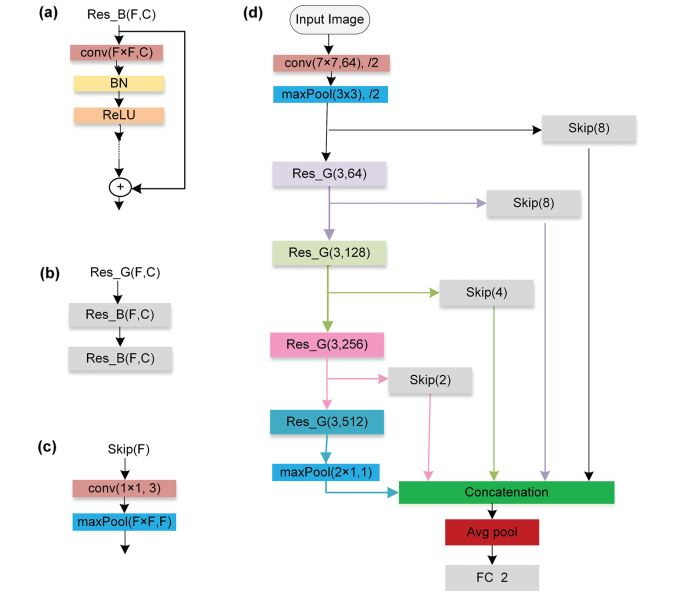

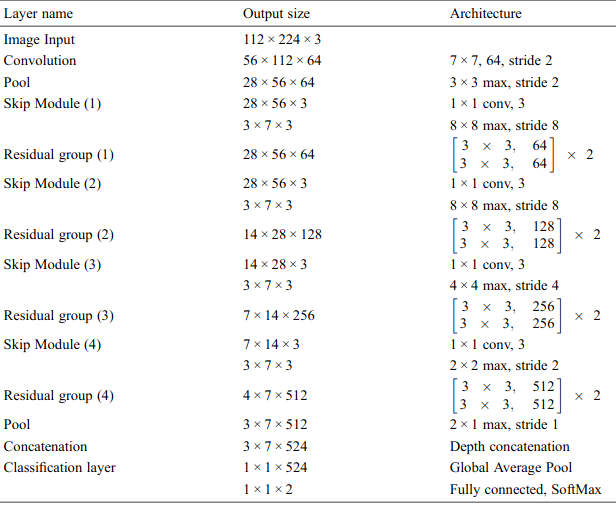

In [77]:
#  The Residual block consists of :
#  Conv_layer_1 ---> Batch_Normalization_1 ---> ReLU_activation_function_1 
#  ---> Conv_layer_2 ---> Batch_Normalization_2 ---> ReLU_activation_function_2 

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        
        print("\nInput shape for resblock : ",x.shape)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        print("ResBlock output shape:", out.shape)
        
        return out

#  The skip connection function consists of simply 2 layers :
#  Conv_layer_1 ---> MaxPool_layer_1
 
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels = 3, kernel_size=1, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8, padding=1)
        
    def forward(self, x):
        #print("Skip connection input shape : ",x.shape)
        out = self.conv(x)
        out = self.pool(out)
        #print("Skip Connection output shape:", out.shape)
        return out
    
#   The Perigender Layer is a combination of the aforementioned function in the following fashion : 
#    
#      1. Conv_layer_1 --> MaxPool2d_1 
#      2. Skip_function_1
#      3. Residual_batch_1             
#      4. Skip_function_2
#      5. Residual_batch_2
#      6. Skip_function_3
#      7. Residual_function_3
#      8. Skip_function_4
#      9. Residual_function_4  
#     10. MaxPool2d_2
#     11. Concatenation_layer_1
#     12. AvgPool_layer


class PeriGender(nn.Module):
    def __init__(self, num_classes=2):
        super(PeriGender, self).__init__()

        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2,padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
        self.skip1 = SkipConnection(64, 64)
        self.resblock1 = nn.Sequential(ResBlock(64, 64, stride=2), ResBlock(64, 128))
        
        self.skip2 = SkipConnection(128, 128)
        self.resblock2 = nn.Sequential(ResBlock(128, 128, stride=2), ResBlock(128, 256))
        
        self.skip3 = SkipConnection(256, 256)
        self.resblock3 = nn.Sequential(ResBlock(256, 256, stride=2), ResBlock(256, 512))
        
        self.skip4 = SkipConnection(512, 512)
        self.resblock4 = nn.Sequential(ResBlock(512, 512, stride=2), ResBlock(512, 512))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        

    def forward(self, x):
        
        print("Input shape : ",x.shape)
   
        out = self.conv(x)
        #print("shape after conv : ",out.shape)
        out = self.maxpool(out)
        #print("shape after maxpool : ",out.shape)
        skip1 = self.skip1(out)
        #print("Shape after skip 1 : ",skip1.shape)
        out = self.resblock1(out)
        print("Shape after residual group 1 : ",out.shape)
        
        skip2 = self.skip2(out)
        out = self.resblock2(out)
        print("Shape after residual group 2: ",out.shape)
        
        skip3 = self.skip3(out)
        out = self.resblock3(out)
        print("Shape after residual group 3 : ",out.shape)
        
        skip4 = self.skip4(out)
        out = self.resblock4(out)
        print("Shape after residual group 4: ",out.shape)
        
        out = self.maxpool(out)

        skip_outputs = [skip1, skip2, skip3, skip4,out]
        concatenated = torch.cat(skip_outputs, dim=1)

        out = self.avgpool(out4)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out  


In [79]:
model = PeriGender()

image = Image.open("/kaggle/working/my-data/ubipr/UBIPeriocular/test/male/C412_S1_I2.jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = transform(image)
image = image.unsqueeze(0)
output = model(image)
print(output)

Input shape :  torch.Size([1, 3, 224, 224])

Input shape for resblock :  torch.Size([1, 64, 56, 56])
ResBlock output shape: torch.Size([1, 64, 14, 14])

Input shape for resblock :  torch.Size([1, 64, 14, 14])
ResBlock output shape: torch.Size([1, 128, 14, 14])
Shape after residual group 1 :  torch.Size([1, 128, 14, 14])

Input shape for resblock :  torch.Size([1, 128, 14, 14])
ResBlock output shape: torch.Size([1, 128, 4, 4])

Input shape for resblock :  torch.Size([1, 128, 4, 4])
ResBlock output shape: torch.Size([1, 256, 4, 4])
Shape after residual group 2:  torch.Size([1, 256, 4, 4])

Input shape for resblock :  torch.Size([1, 256, 4, 4])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

# Training and testing loop
In this section we will 

1.   Define the required data transformation functions, Loss function, Optimizer function (SGDM, not ADAM)

2.   Build the Training-Testing loop





In [14]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create data loaders for train and test sets
train_set = ImageFolder('/kaggle/working/my-data/ubipr/UBIPeriocular/train', transform=transform)
test_set = ImageFolder('/kaggle/working/my-data/ubipr/UBIPeriocular/test', transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# Initialize the model
model = PeriGender(num_classes=2)

# Define an optimizer function
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model
num_epochs = 10
# for images, labels in train_loader:
#     print(images.shape)
#     print(labels.shape)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        
        # Move the data to the correct device by using device agnostic code
        images = images.to(device)
        print(images.shape)
        labels = labels.to(device)
        print(labels.shape)
        
        # Do the forward pass
        outputs = model(images)
        print(outputs.shape)
        
        # Calculate the loss
        loss = loss_fn(outputs, labels)
        
        # Optmizer zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), running_loss/10))
            running_loss = 0.0


torch.Size([64, 3, 224, 224])
torch.Size([64])
input shape :  torch.Size([64, 3, 224, 224])
shape after conv :  torch.Size([64, 3, 224, 224])
shape after maxpool :  torch.Size([64, 3, 224, 224])
shape after conv1:  torch.Size([64, 3, 224, 224])
shape after bn1 :  torch.Size([64, 3, 224, 224])
shape after relu :  torch.Size([64, 3, 224, 224])


RuntimeError: Given groups=1, weight of size [64, 64, 3, 3], expected input[64, 1, 26, 26] to have 64 channels, but got 1 channels instead